# Agenda  <a name="backtotop"></a>
---

1. [General Trend](#GT)
2. [Fit By Logistic Regression](#LR)
3. [Fit By Multinomial Naive Bayes](#MNB)
4. [Fit By Random Forest](#RF)

## Libraries

In [96]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import re
from tqdm import tqdm

## Raw Data

In [3]:
path = "data/"
DJIA_fn = "DJIA_table.csv"
News_fn = "Combined_News_DJIA.csv"

DJIA_df = pd.read_csv(path + DJIA_fn)
DJIA_df = DJIA_df.sort_values("Date")
DJIA_df.index = range(len(DJIA_df))

News_df = pd.read_csv(path + News_fn)
News_df = News_df.sort_values("Date")
News_df.index = range(len(News_df))

## General Trend <a name = "GT"></a>

[Back to Top](#backtotop)

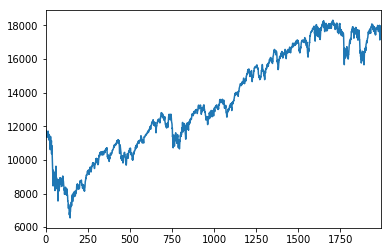

In [4]:
DJIA_df["Adj Close"].plot()
plt.show()

## Clean data in News_df

In [5]:
def RemoveQuote(tmp_str):
    s_quote = False
    d_quote = False
    start_list = []
    end_list = []
    mid_str = tmp_str[5:len(tmp_str)-5]
    for i in range(5):
        if (not s_quote) or (not d_quote):
            try:
                if tmp_str[i] != "\'" and tmp_str[i] != "\"":
                    if i <=2 and tmp_str[i] == 'b':
                        continue
                    start_list.append(tmp_str[i])
                if tmp_str[-5+i] != "'" and tmp_str[-5+i] != '"':
                    end_list.append(tmp_str[-5+i])
            except:
                print(tmp_str)

    tmp_str = "".join(start_list) + mid_str + "".join(end_list)
    return tmp_str

headline_columns = [x for x in News_df.columns if re.match("Top", x)]
for col in headline_columns:
    News_df[col] = News_df[col].apply(lambda x: RemoveQuote(x) if x == x else x)
Comb_df = DJIA_df.merge(News_df, on = "Date", how = "inner")

## Make Training Data and Testing Data (8:2)

In [6]:
train_index = pd.to_datetime(DJIA_df.Date, format = "%Y-%m-%d") < pd.to_datetime("2014-12-31", format = "%Y-%m-%d")
train_data = Comb_df[train_index]
test_data = Comb_df[~train_index]

## Joint Top Hottest Headlines and Tokenize and Vecterize Text into Metrix

In [29]:
joint_headlines_train = train_data[headline_columns[0]]
joint_headlines_test = test_data[headline_columns[0]]
for i in range(1, len(headline_columns)):
    joint_headlines_train += (' ' + train_data[headline_columns[i]].apply(lambda x: str(x) if x == x else ""))
    joint_headlines_test += (' ' + test_data[headline_columns[i]].apply(lambda x: str(x) if x == x else ""))

basicVetorizer = TfidfVectorizer(min_df=0.03, max_df=0.97, max_features = 200000, ngram_range = (2, 2))
basic_train = basicVetorizer.fit_transform([x for x in joint_headlines_train.values if x == x])
basic_test = basicVetorizer.transform([x for x in joint_headlines_test.values if x == x])
basic_whole = basicVetorizer.fit_transform([x for x in joint_headlines_train.append(joint_headlines_test).values if x==x])

# Fit by Logistic Regression <a name = "LR"></a>
    
[Back to Top](#backtotop)
> Find the best score by Grid Search on Penalty C <br>
> **Assumptions:** <br>
> - The outcome is binary <br>
> - The observations are independent to each other <br>
> - Absence of multicollinearity <br>
> - Linearity of independent variables and log odds <br>
> - Large size of database <br>


In [12]:

logistic_model = LogisticRegression(solver='lbfgs')
# logistic_model = logistic_model.fit(basic_train, train_data.Label)


gs = GridSearchCV(logistic_model, {'C': [0.001,0.01,0.1,1,10,100,1000]}, cv = 12, scoring='accuracy',)
gs.fit(TruncatedSVD(n_components=10).fit_transform(basicVetorizer.fit_transform([x for x in joint_headlines_train.append(joint_headlines_test).values if x == x])), Comb_df.Label.values)

print("Best Score = ", gs.best_score_)

Best Score =  0.5359477124183006


**Comment**:
> Logistic perform the best when C is around 0.001
> The length of tokens does not really change the accuracy (tried 1-3 grams)

## Reduce Tfidf Dimension by TruncatedSVD (PCA does not adapt to sparse matrix)

In [13]:
from sklearn.decomposition import TruncatedSVD
accuracy_list = []

for num_compo in range(1, 632):
    SVD_model = TruncatedSVD(n_components=num_compo)
    basic_train_svd = SVD_model.fit_transform(basic_train)
    basic_test_svd = SVD_model.transform(basic_test)
    logistic_model = logistic_model.fit(basic_train_svd, train_data.Label)
    accuracy_list.append(accuracy_score(logistic_model.predict(basic_test_svd), test_data.Label))

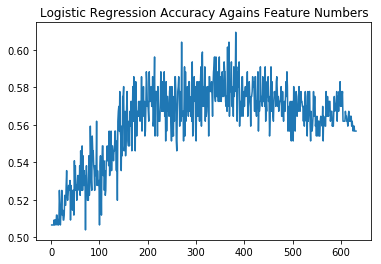

In [14]:
plt.plot(range(1, 632), accuracy_list)
plt.title("Logistic Regression Accuracy Agains Feature Numbers")
plt.show()

**Comment:**
> The graph shows the extraordinary features pottentially reduce the accruacy from 0.02-0.01 <br>
> The most ideal accruacy was made at around 480 number of features <br>

# Fit by Multinomial Naive Bayes <a name = "MNB"></a>

[Back to Top](#backtotop)

In [64]:
NB_model = MultinomialNB()
param = {"alpha": np.arange(0, 10, 0.2)}
gd_NB = GridSearchCV(NB_model, param, cv = 5)
gd_NB.fit(basic_whole, Comb_df.Label.values)
print("Best Score = %.2f with alpha = %.2f"%(gd_NB.best_score_, gd_NB.best_params_['alpha'] ))

/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Best Score = 0.54 with alpha = 3.60


## Reduce Tfidf Dimension by TruncatedSVD (PCA does not adapt to sparse matrix)
**Notice**: <br>
By practice, this won't work since SVD created negative input for naive base, **which is not allowed**
<br>
```python 
SVD_model = TruncatedSVD(n_components=380)
basic_train_svd = SVD_model.fit_transform(basic_train)
basic_test_svd = SVD_model.transform(basic_test)

NB_model = MultinomialNB()
NB_model = NB_model.fit(basic_train_svd, train_data.Label.values)
accuracy_score(NB_model.predict(basic_test_svd), test_data.Label.values)
```

# Fit by Random Forest <a name = "RF"></a>

[Back to Top](#backtotop)

**Comment:**<br>
- Even it is not shown below, I tuned the model by **N_estimators, max_depth, min_samples_split, min_samples_leaf, max_features** respectively but the accuracy did not indicate any strong changes

In [98]:
accuracy_list = []
cv = 10
cv_list = []
for i in range(cv):
    RF_model = RandomForestClassifier(n_estimators= 32)
    RF_model = RF_model.fit(basic_train, train_data.Label.values)
    cv_list.append(accuracy_score(RF_model.predict(basic_test), test_data.Label.values))
new_accuracy = np.average(cv_list)
print("Average accuarcy = ", new_accuracy)

Average accuarcy =  0.5189973614775726


### TruncatedSVD + Random Forest
**Comment:**
- The dimension reduction does not really improve the prediction

In [99]:
accuracy_list = []
RF_model = RandomForestClassifier(n_estimators= 32)
rang = range(1, 632)
for num_compo in tqdm(rang):
    SVD_model = TruncatedSVD(n_components=num_compo)
    basic_train_svd = SVD_model.fit_transform(basic_train)
    basic_test_svd = SVD_model.transform(basic_test)
    RF_model = RF_model.fit(basic_train_svd, train_data.Label)
    accuracy_list.append(accuracy_score(RF_model.predict(basic_test_svd), test_data.Label))

100%|██████████| 631/631 [06:20<00:00,  1.01it/s]


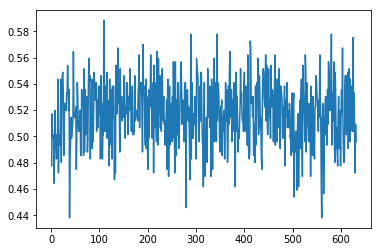

In [102]:
plt.plot(rang, accuracy_list)
plt.show()